In [4]:
import pandas as pd
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np

# 1. Get the dataset

In [5]:
try:
    raw_df = pd.read_json("../data/dataset.json")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'dataset.json' not found. Please download it and place it in the correct directory.")

print("\n--- Data Info ---")
raw_df.info()

print("\n--- First 5 Rows ---")
print(raw_df.head())

print(f"\nDataset shape: {raw_df.shape}")

Dataset loaded successfully.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   giver_username_if_known                               4040 non-null   object 
 1   number_of_downvotes_of_request_at_retrieval           4040 non-null   int64  
 2   number_of_upvotes_of_request_at_retrieval             4040 non-null   int64  
 3   post_was_edited                                       4040 non-null   int64  
 4   request_id                                            4040 non-null   object 
 5   request_number_of_comments_at_retrieval               4040 non-null   int64  
 6   request_text                                          4040 non-null   object 
 7   request_text_edit_aware                               4040 non-null   object 
 8   request_ti

# 2. Clean the dataset

In [6]:
df = raw_df.copy()

# We don't use unix_timestamp_of_request because it uses incorrect timezone according to the dataset description.
df["request_datetime_utc"] = pd.to_datetime(
    df["unix_timestamp_of_request_utc"], unit="s"
)
# We can drop the original unix columns as they are now redundant
df.drop(
    ["unix_timestamp_of_request", "unix_timestamp_of_request_utc"], axis=1, inplace=True
)
# Redundant with request_text_edit_aware that is cleaned.
df.drop(
    "request_text",axis=1, inplace=True         
)
# The column 'giver_username_if_known' uses the string 'N/A' for missing values.
# Standardizing this to NumPy's `np.nan` makes it easier to work with pandas'
# built-in functions for handling missing data (e.g., .isnull(), .fillna()).
# The same applies to `requester_user_flair` which has string 'None'.
df["giver_username_if_known"].replace("N/A", np.nan, inplace=True)
df["requester_user_flair"].replace("None", np.nan, inplace=True)

num_duplicates = df.duplicated(subset=["request_id"]).sum()
if num_duplicates > 0:
    print(f"Found {num_duplicates} duplicate requests. Removing them.")
    df.drop_duplicates(subset=["request_id"], keep="first", inplace=True)
else:
    print("No duplicate requests found based on 'request_id'.")

No duplicate requests found based on 'request_id'.


# 3. Statistics

### a. What is the prevalence for a requester to be given a pizza?

In [7]:
# Prevalence of receiving a pizza
prevalence = df['requester_received_pizza'].mean()
print(f"\nPrevalence of receiving a pizza: {prevalence:.2%}")
print(f"This means that about 1 in {1/prevalence:.1f} requests were successful.")


Prevalence of receiving a pizza: 24.60%
This means that about 1 in 4.1 requests were successful.


### b. What are the top 10 subreddits the requesters have already posted in the most?



--- Top 10 Subreddits by Requester Activity ---
requester_subreddits_at_request
AskReddit               2307
pics                    1949
funny                   1932
WTF                     1515
IAmA                    1507
gaming                  1485
Random_Acts_Of_Pizza    1413
videos                  1160
todayilearned           1103
AdviceAnimals           1021
Name: count, dtype: int64


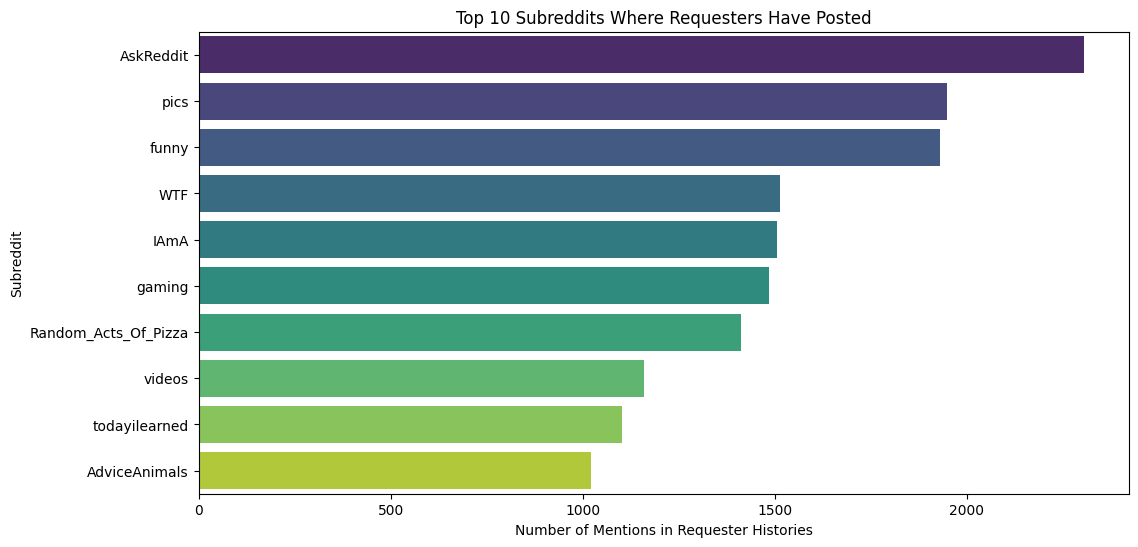

In [8]:
# Explode the requester_subreddits_at_request column then count and retrieve the top 10 subreddits
top_10_subreddits = (
    df["requester_subreddits_at_request"]
    .explode()
    .value_counts()
    .head(10)
)


print("\n--- Top 10 Subreddits by Requester Activity ---")
print(top_10_subreddits)

# Visualize the result
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_subreddits.values, y=top_10_subreddits.index, palette='viridis',hue=top_10_subreddits.index)
plt.title('Top 10 Subreddits Where Requesters Have Posted')
plt.xlabel('Number of Mentions in Requester Histories')
plt.ylabel('Subreddit')
plt.show()

### c. For each of these top 10 subreddits and for each month of data, how many of their active users requested a pizza in the past 6 months?

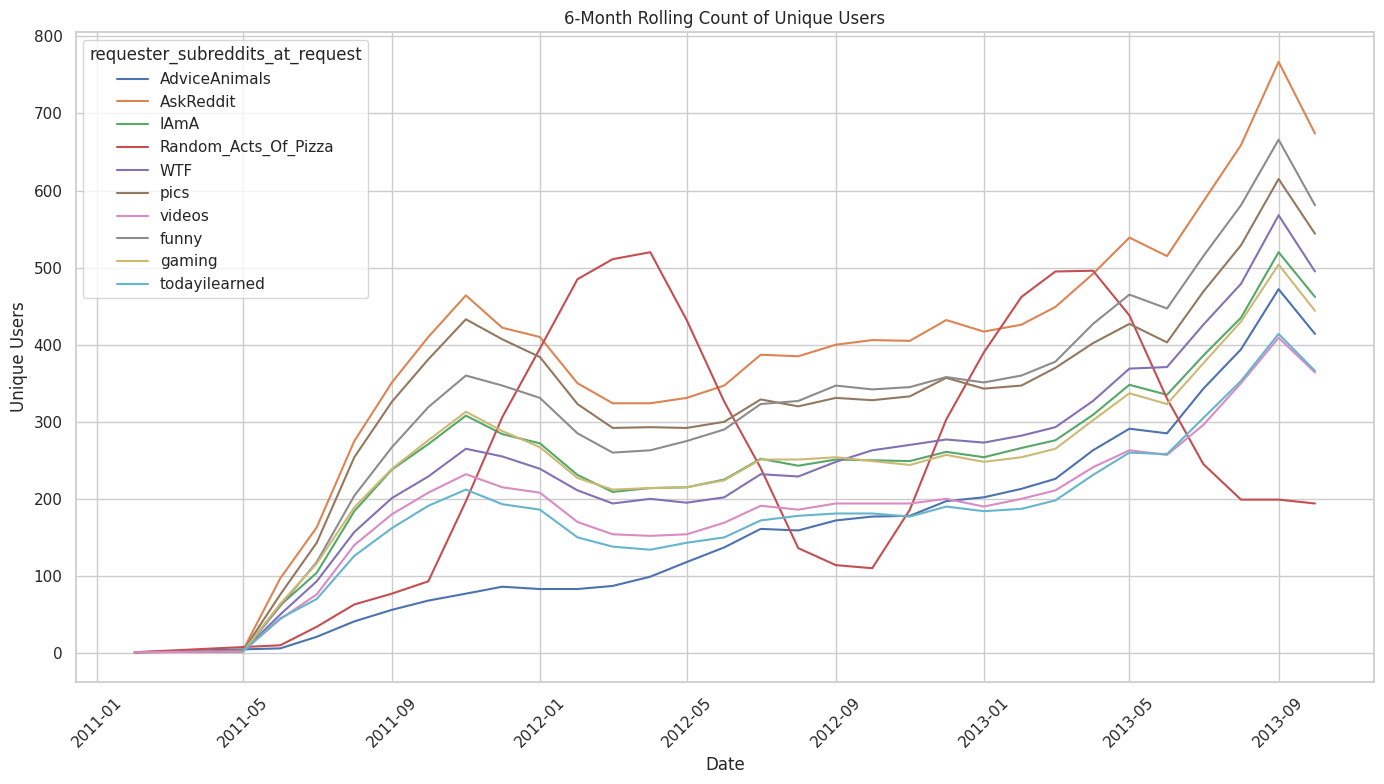

In [9]:
top_10_subreddits_list = top_10_subreddits.index.tolist()
# We explode the 'requester_subreddits_at_request', ie 1 row [['subreddit1', 'subreddit2']] ->  2 rows ['subreddit1', 'subreddit2']
df_clean_exploded = df.explode("requester_subreddits_at_request")
# We filter the DataFrame to only include rows where the subreddit is in the top 10
df_top_10_subreddits = df_clean_exploded[
    df_clean_exploded["requester_subreddits_at_request"].isin(top_10_subreddits_list)
].copy()
# New column for the year and month of the request
df_top_10_subreddits["year_month"] = df_top_10_subreddits[
    "request_datetime_utc"
].dt.to_period("M")

# We get the unique usernames list for each subreddit and month
active_user_month_sub = df_top_10_subreddits.groupby(
    ["year_month", "requester_subreddits_at_request"]
)["requester_username"].unique()

# First I tried using .rolling() but it seems to be only fitted for numeric data. 
# "DataError: No numeric types to aggregate"
# So instead we are doing the rolling unique count manually.

def calculate_rolling_unique_count(series_of_lists):
    rolling_counts = []
    for i in range(len(series_of_lists)):
        start_index = max(0, i - 5)
        window = series_of_lists[start_index : i + 1]
        count = window.explode().nunique()
        rolling_counts.append(count)
    return pd.Series(rolling_counts, index=series_of_lists.index)

final_result = active_user_month_sub.groupby(
    "requester_subreddits_at_request",
     group_keys=False       
).apply(
    calculate_rolling_unique_count
)

# Convert the Series with its MultiIndex into a cleaner DataFrame, reset_index() turns the index levels into columns, 'name' gives the data column a name.
final_result = final_result.reset_index(name="rolling_count")
# 3 cols 'year_month', 'requester_subreddits_at_request', 'rolling_count'

def plot_rolling_data(df_plot):
    # Convert the 'year_month' Period objects into Timestamps for better plotting.
    df_plot["year_month"] = df_plot["year_month"].dt.to_timestamp()

    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    sns.lineplot(
        data=df_plot,
        x="year_month",
        y="rolling_count",
        hue="requester_subreddits_at_request",
    )

    plt.title("6-Month Rolling Count of Unique Users")
    plt.ylabel("Unique Users")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_rolling_data(final_result)

### d. What is the average time between two consecutive requests for each month, only for months with at least 50 requests?


In [10]:
df_analysed = df.copy()
df_analysed["year_month"] = df_analysed["request_datetime_utc"].dt.to_period("M")
df_analysed.sort_values(by="request_datetime_utc", inplace=True)
# Calculate the time difference between requests
df_analysed["time_between_requests"] = df_analysed["request_datetime_utc"].diff()


In [11]:
#  combines the filtering and aggregation
average_time_per_month = (
    df_analysed.groupby("year_month")
    .filter(
        lambda group: len(group) >= 50
    )  # This keeps only the groups that have 50+ rows
    .groupby("year_month")[
        "time_between_requests"
    ] 
    .mean()
)

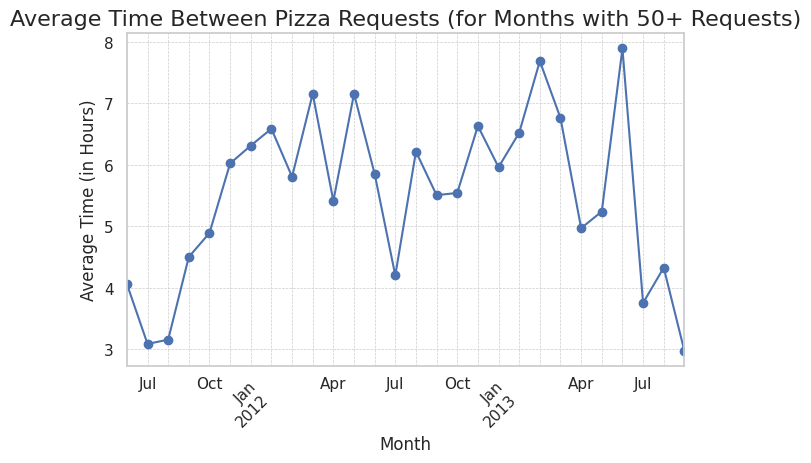

In [12]:
# Plotting
average_hours_per_month = average_time_per_month.dt.total_seconds() / 3600
#  is a PeriodIndex, convert it to string for cleaner labels
average_hours_per_month.index = average_hours_per_month.index.to_timestamp()

average_hours_per_month.plot(kind='line', marker='o', linestyle='-')

plt.title('Average Time Between Pizza Requests (for Months with 50+ Requests)', fontsize=16)
plt.ylabel('Average Time (in Hours)', fontsize=12)
plt.xlabel('Month', fontsize=12)
# improve readability
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() # Adjust layout to make sure everything fits

plt.show()

# 4. Preprocess the data for the task.

## Adressing Data Leakage

We choose to remove the column "_at_retrieval", to prevent data leakage. We want to predict "whether a requester will be given a pizza or not". Using information at retrieval is a little bit like cheating. We can suppose for instance that successfull request will be more upvoted by the community, "number_of_upvotes_of_request_at_retrieval" could give us the anwser.

In [13]:
df_clean = df.copy()
# We dont want to use any data that was collected after the request was made.
retrieval_cols = [col for col in df_clean.columns if "_at_retrieval" in col]
df_clean = df_clean.drop(columns=retrieval_cols)
print(f"Dropped {len(retrieval_cols)} data leakage columns.")
# We remove "requester_user_flair_at_retrieval" as it is assigned after the event. It's another direct leak.
df_clean = df_clean.drop(columns=["requester_user_flair"])
# We also remove "giver_username_if_known" You can only know this if the request was successful. This is a direct leak of the answer
df_clean = df_clean.drop(columns=["giver_username_if_known"])
df_clean.info()
# We also remove the 'post_was_edited' Because the edit often happens after the outcome is known, the post_was_edited flag contains information about the outcome.
df_clean = df_clean.drop(columns=["post_was_edited"])

# save the dataset as cleaned_dataset.json
df_clean.to_json("cleaned_dataset.json")

Dropped 11 data leakage columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   post_was_edited                                     4040 non-null   int64         
 1   request_id                                          4040 non-null   object        
 2   request_text_edit_aware                             4040 non-null   object        
 3   request_title                                       4040 non-null   object        
 4   requester_account_age_in_days_at_request            4040 non-null   float64       
 5   requester_days_since_first_post_on_raop_at_request  4040 non-null   float64       
 6   requester_number_of_comments_at_request             4040 non-null   int64         
 7   requester_number_of_comments_in_raop_at_request     4040 non-nu

## Feature Exploration

Prevalence of successful requests (requester received pizza): 24.60%


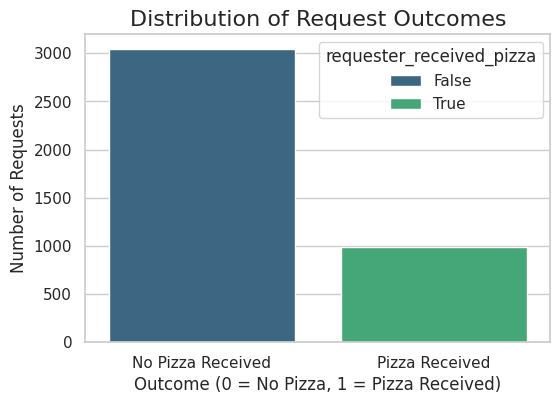

In [14]:

prevalence = df["requester_received_pizza"].mean()
print(f"Prevalence of successful requests (requester received pizza): {prevalence:.2%}")

# Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x="requester_received_pizza", data=df, palette="viridis",hue="requester_received_pizza")
plt.title("Distribution of Request Outcomes", fontsize=16)
plt.ylabel("Number of Requests")
plt.xlabel("Outcome (0 = No Pizza, 1 = Pizza Received)")
plt.xticks([0, 1], ["No Pizza Received", "Pizza Received"])
plt.show()


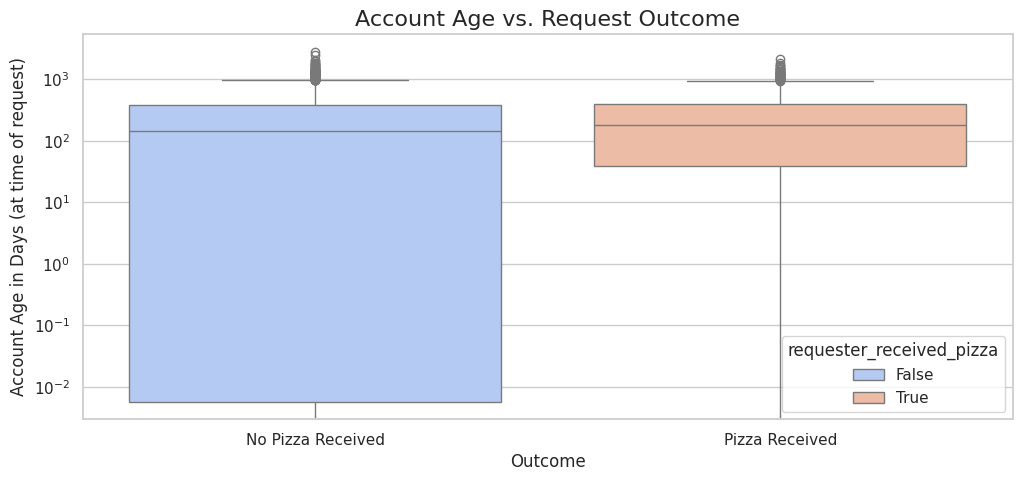

Filtering Karma plot to values below the 95th percentile: 5217


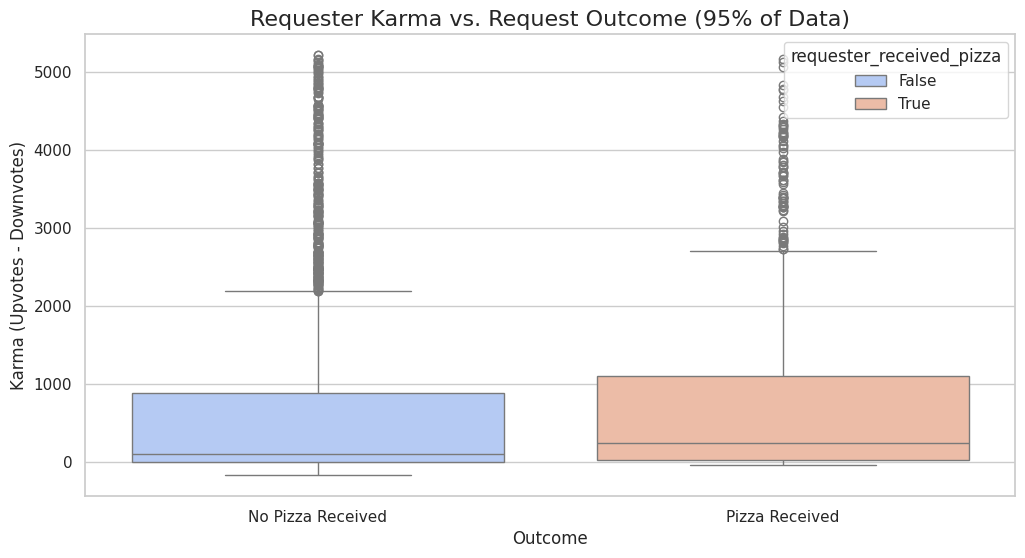

In [15]:
# A Requester Account Age
plt.figure(figsize=(12, 5))
sns.boxplot(
    x="requester_received_pizza",
    y="requester_account_age_in_days_at_request",
    data=df,
    palette="coolwarm",
    hue="requester_received_pizza",
)
plt.title("Account Age vs. Request Outcome", fontsize=16)
plt.ylabel("Account Age in Days (at time of request)")
plt.xlabel("Outcome")
plt.xticks([0, 1], ["No Pizza Received", "Pizza Received"])
# Using a log scale can help if the data is heavily skewed
plt.yscale("log")
plt.show()

# B Requester Karma 
# Calculate the 95th percentile to use as a cutoff
karma_cutoff = df["requester_upvotes_minus_downvotes_at_request"].quantile(0.95)
print(f"Filtering Karma plot to values below the 95th percentile: {karma_cutoff:.0f}")

plt.figure(figsize=(12, 6))
# Use a temporary DataFrame with outliers removed for plotting
sns.boxplot(
    x="requester_received_pizza",
    y="requester_upvotes_minus_downvotes_at_request",
    data=df[
        df["requester_upvotes_minus_downvotes_at_request"] < karma_cutoff
    ],
    palette="coolwarm",
    hue="requester_received_pizza",
)
plt.title("Requester Karma vs. Request Outcome (95% of Data)", fontsize=16)
plt.ylabel("Karma (Upvotes - Downvotes)")
plt.xlabel("Outcome")
plt.xticks([0, 1], ["No Pizza Received", "Pizza Received"])
plt.show()

Account Age vs. Request Outcome:

While the median account age is similar for both groups, requesters who successfully receive a pizza tend to have a slightly older and more established reddit account.


Requester Karma vs. Request Outcome: 

Users who successfully receive a pizza typically have slightly higher karma to those who do not


--- Analysis of Request-Level Features ---
Filtering Request Length plot to values below the 95th percentile: 1042


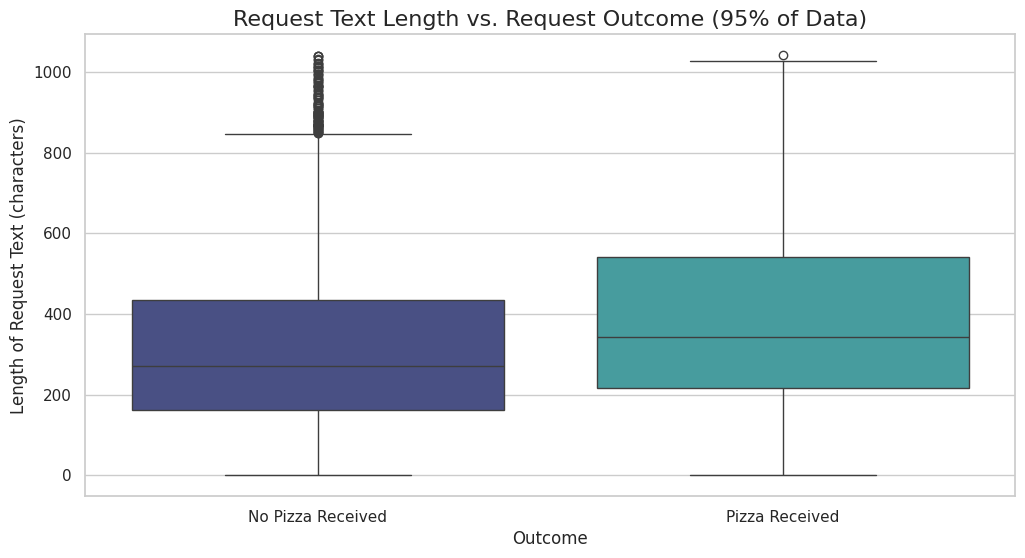

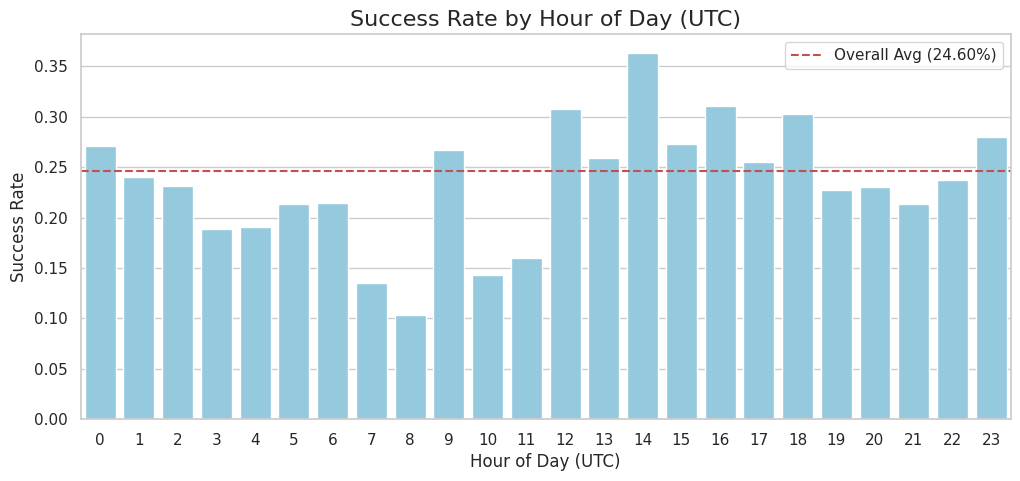

In [16]:
print("\n--- Analysis of Request-Level Features ---")

# A Request Length
df["request_length"] = df["request_text_edit_aware"].str.len()
length_cutoff = df["request_length"].quantile(0.95)
print(
    f"Filtering Request Length plot to values below the 95th percentile: {length_cutoff:.0f}"
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    x="requester_received_pizza",
    y="request_length",
    data=df[
        df["request_length"] < length_cutoff
    ],  
    palette="mako",
)
plt.title("Request Text Length vs. Request Outcome (95% of Data)", fontsize=16)
plt.ylabel("Length of Request Text (characters)")
plt.xlabel("Outcome")
plt.xticks([0, 1], ["No Pizza Received", "Pizza Received"])
plt.show()

# B Hour of Day
# create the time features
df["hour_of_request"] = df["request_datetime_utc"].dt.hour

# calculate success rate by hour
hourly_success_rate = (
    df.groupby("hour_of_request")["requester_received_pizza"].mean().reset_index()
)

plt.figure(figsize=(12, 5))
sns.barplot(
    x="hour_of_request",
    y="requester_received_pizza",
    data=hourly_success_rate,
    color="skyblue",
)
plt.axhline(
    y=prevalence, color="r", linestyle="--", label=f"Overall Avg ({prevalence:.2%})"
)
plt.title("Success Rate by Hour of Day (UTC)", fontsize=16)
plt.ylabel("Success Rate")
plt.xlabel("Hour of Day (UTC)")
plt.legend()
plt.show()


Request Text Length vs. Request Outcome

Successful pizza requests are, on average, longer (median length ~350 characters) and have a wider range of lengths compared to unsuccessful requests (median length ~270 characters), suggesting that more detailed posts are more persuasive.


Success Rate by Hour of Day

The probability of a request being successful varies notably throughout the day, peaking significantly during the 14:00 UTC hour (around 36%) and showing a clear dip in the morning hours from 7:00 to 10:00 UTC.


--- Calculating Single-Feature F1 Score for All Features ---


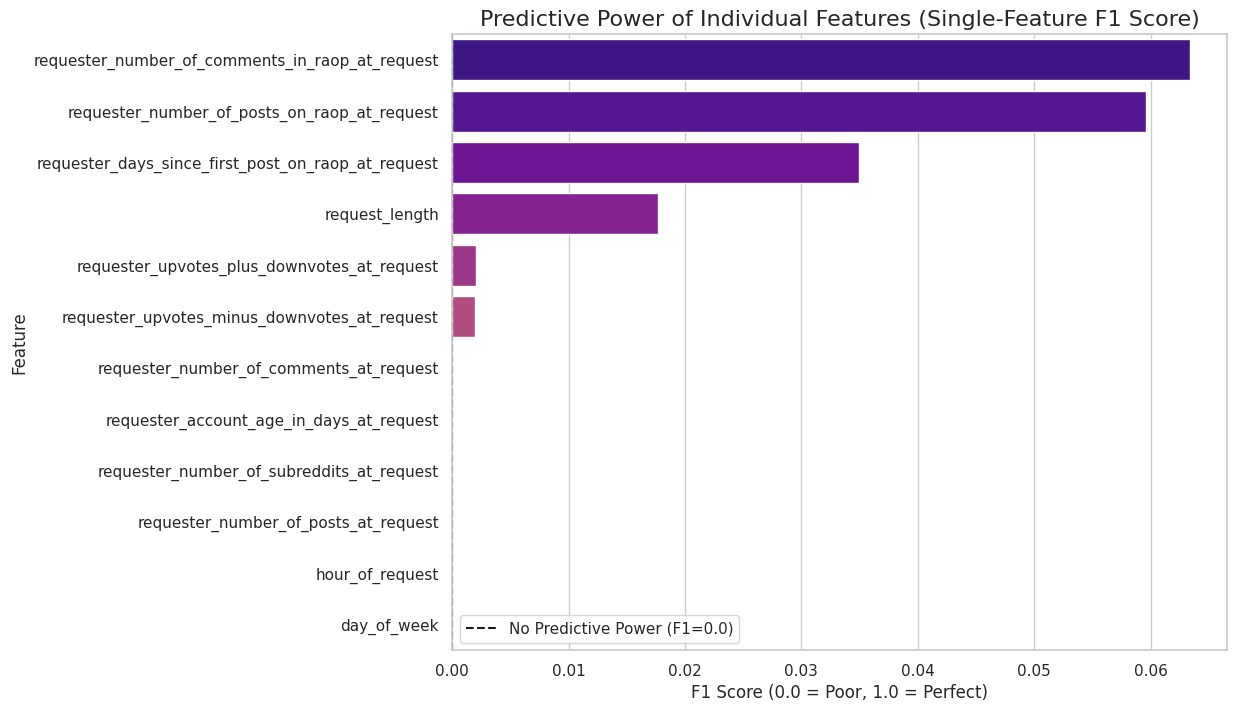


--- Top 5 Features by F1 Score ---
requester_number_of_comments_in_raop_at_request       0.063401
requester_number_of_posts_on_raop_at_request          0.059615
requester_days_since_first_post_on_raop_at_request    0.034985
request_length                                        0.017647
requester_upvotes_plus_downvotes_at_request           0.002008
dtype: float64


In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score  # Changed from roc_auc_score
import warnings

warnings.filterwarnings("ignore")

# Single-Feature F1 Score to Measure Predictive Power
print("\n--- Calculating Single-Feature F1 Score for All Features ---")
df["request_length"] = df["request_text_edit_aware"].str.len().fillna(0)

# Define our feature lists again for clarity
numeric_features = [
    "requester_account_age_in_days_at_request",
    "requester_days_since_first_post_on_raop_at_request",
    "requester_number_of_comments_at_request",
    "requester_number_of_comments_in_raop_at_request",
    "requester_number_of_posts_at_request",
    "requester_number_of_posts_on_raop_at_request",
    "requester_number_of_subreddits_at_request",
    "requester_upvotes_minus_downvotes_at_request",
    "requester_upvotes_plus_downvotes_at_request",
    "request_length",
]
categorical_features = ["hour_of_request", "day_of_week"]

# Combine all features we want to test
all_features = numeric_features + categorical_features
f1_scores = {}  # Changed from auc_scores

# df["hour_of_request"] = df["request_datetime_utc"].dt.hour
df["day_of_week"] = df["request_datetime_utc"].dt.dayofweek

for feature in all_features:
    # Build a tiny pipeline to process this one feature
    # It will OneHotEncode categoricals and pass numerics through
    preprocessor = ColumnTransformer(
        [
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore"),
                [feature]
                if df[feature].dtype == "object" or feature in categorical_features
                else [],
            )
        ],
        remainder="passthrough",
    )

    model_pipeline = make_pipeline(preprocessor, LogisticRegression())

    # Fit the model on the training data for that single feature
    model_pipeline.fit(df[[feature]], df["requester_received_pizza"])

    # Get the class predictions (not probabilities)
    y_pred = model_pipeline.predict(df[[feature]])  # Changed from predict_proba

    # Calculate and store the F1 score
    f1_scores[feature] = f1_score(
        df["requester_received_pizza"], y_pred
    )  # Changed metric

# Convert to a sorted Series for plotting
f1_series = pd.Series(f1_scores).sort_values(ascending=False)  # Changed variable name

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x=f1_series.values, y=f1_series.index, palette="plasma")
plt.title(
    "Predictive Power of Individual Features (Single-Feature F1 Score)",
    fontsize=16,  # Updated title
)
plt.xlabel("F1 Score (0.0 = Poor, 1.0 = Perfect)")  # Updated label
plt.ylabel("Feature")
plt.axvline(
    x=0.0, color="k", linestyle="--", label="No Predictive Power (F1=0.0)"
)  # Updated reference line
plt.legend()
plt.show()

# Print top performing features
print(f"\n--- Top 5 Features by F1 Score ---")
print(f1_series.head())


## Feature Engineering

In [18]:
X = df.copy()
X.drop(columns=["requester_received_pizza"], inplace=True)

# Length of Request: A very long, detailed request might be more convincing than a short one.    
X['request_length'] = X['request_text_edit_aware'].str.len()

#Time of Day: Maybe requests made around dinner time are more likely to be fulfilled.      
X['hour_of_request'] = X['request_datetime_utc'].dt.hour
# Day of the Week: A "Friday pizza night" request might have a different success rate.
X['day_of_week'] = X['request_datetime_utc'].dt.dayofweek # Monday=0, Sunday=6
# Is this account only created for RAOP? Or is it a long-time user?
X['raop_post_ratio'] = X['requester_number_of_posts_on_raop_at_request'] / (X['requester_number_of_posts_at_request'] + 1e-6)
# Combine the two text columns into one.
X['full_request_text'] = X['request_title'].fillna('') + ' ' + X['request_text_edit_aware'].fillna('') + X["requester_username"].fillna('')

columns_to_drop = [
    # These have been combined into 'full_request_text'
    'request_title',
    'request_text_edit_aware',
    'requester_username',
    # These are identifiers or raw data we've already used for feature engineering
    'request_datetime_utc',
    
    #request_id, model can't learn a pattern from request_id
    "request_id", 
    # We already have 'requester_number_of_subreddits_at_request' which captures some of this info.
    "requester_subreddits_at_request",  # This is a list of strings, hard to encode directly.
]

X_final = X.drop(columns=columns_to_drop)
# print columns and their types
print("\n--- Feature Columns and Types ---")
print(X.dtypes)



--- Feature Columns and Types ---
giver_username_if_known                                         object
number_of_downvotes_of_request_at_retrieval                      int64
number_of_upvotes_of_request_at_retrieval                        int64
post_was_edited                                                  int64
request_id                                                      object
request_number_of_comments_at_retrieval                          int64
request_text_edit_aware                                         object
request_title                                                   object
requester_account_age_in_days_at_request                       float64
requester_account_age_in_days_at_retrieval                     float64
requester_days_since_first_post_on_raop_at_request             float64
requester_days_since_first_post_on_raop_at_retrieval           float64
requester_number_of_comments_at_request                          int64
requester_number_of_comments_at_retrieval 

In [19]:
numeric_features = [
    'requester_account_age_in_days_at_request',
    'requester_days_since_first_post_on_raop_at_request',
    'requester_number_of_comments_at_request',
    'requester_number_of_comments_in_raop_at_request',
    'requester_number_of_posts_at_request',
    'requester_number_of_posts_on_raop_at_request',
    'requester_number_of_subreddits_at_request',
    'requester_upvotes_minus_downvotes_at_request',
    'requester_upvotes_plus_downvotes_at_request',
    'request_length',
    'raop_post_ratio'
]

categorical_features = [
    'hour_of_request',
    'day_of_week'
]

text_feature = 'full_request_text'

After exploration on this notebook, I created a file were the pipeline for processing of the data is cleanly implemented: src/pipeline.py

The next notebook to look for the analysis is building_ml_model.ipynb